In [22]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [23]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM

import PyPlot; const plt = PyPlot ;
include("../saftvrmienn.jl") ;

In [24]:
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1) ;

In [25]:
header_names = ["epoch", "species", "Mw", "m", "σ", "λ_a", "λ_r", "ϵ"]
# raw_params = CSV.File("../params_logs/params_data_150_iters_5x_lr.txt"; header=header_names) |> DataFrame
raw_params = CSV.File("../params_log_linear_alkanes_10k.csv"; header=header_names) |> DataFrame
# raw_params2 = CSV.File("../params_logs/params_log_all_alkanes_sat_v_1k_epochs.csv"; header=header_names) |> DataFrame ;
# raw_params1 = CSV.File("../params_logs/params_log_all_alkanes_sat_v_500_epochs.csv"; header=header_names) |> DataFrame ;

In [26]:
unique_values = unique(raw_params[!, :species])
num_rows = length(unique_values)

processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    m = fill([0.0], num_rows), 
    σ = fill([0.0], num_rows),
    λ_a = fill([0.0], num_rows),
    λ_r = fill([0.0], num_rows),
    ϵ = fill([0.0], num_rows)
) ;

processed_data.species = unique_values ;

In [27]:
for i in unique_values
    raw_params_spec = filter(row -> isequal(row.species, i), raw_params)
    num_epochs = nrow(raw_params_spec)

    row_number_processed = findall(isequal(i), processed_data.species)
    row_number_source = findall(isequal(i), pcp_source_params.species)

    processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
    processed_data[row_number_processed,:Mw] = [raw_params_spec[1,:Mw]]
    processed_data[row_number_processed,:m] = [[raw_params_spec[i,:m] for i = 1:num_epochs]]
    processed_data[row_number_processed,:σ] = [[raw_params_spec[i,:σ] for i = 1:num_epochs]]
    processed_data[row_number_processed,:ϵ] = [[raw_params_spec[i,:ϵ] for i = 1:num_epochs]]
    processed_data[row_number_processed,:λ_a] = [[raw_params_spec[i,:λ_a] for i = 1:num_epochs]]
    processed_data[row_number_processed,:λ_r] = [[raw_params_spec[i,:λ_r] for i = 1:num_epochs]]
    
end

processed_data = sort(processed_data, :Mw) ;

In [28]:
# for i in unique_values
#         raw_params_spec_1 = filter(row -> isequal(row.species, i), raw_params1)
#         raw_params_spec_2 = filter(row -> isequal(row.species, i), raw_params2)

#         num_epochs = nrow(raw_params_spec_1)
    
#         row_number_processed = findall(isequal(i), processed_data.species)
#         row_number_source = findall(isequal(i), pcp_source_params.species)
    
#         processed_data[row_number_processed,:isomeric_SMILES] = pcp_source_params[row_number_source,:isomeric_SMILES]
#         processed_data[row_number_processed,:Mw] = [raw_params_spec_1[1,:Mw]]
#         processed_data[row_number_processed,:m] = [vcat([raw_params_spec_1[i,:m] for i = 1:num_epochs],[raw_params_spec_2[i,:m] for i = 1:num_epochs])]
#         processed_data[row_number_processed,:σ] = [vcat([raw_params_spec_1[i,:σ] for i = 1:num_epochs],[raw_params_spec_2[i,:σ] for i = 1:num_epochs])]
#         processed_data[row_number_processed,:ϵ] = [vcat([raw_params_spec_1[i,:ϵ] for i = 1:num_epochs],[raw_params_spec_2[i,:ϵ] for i = 1:num_epochs])]
#         processed_data[row_number_processed,:λ_a] = [vcat([raw_params_spec_1[i,:λ_a] for i = 1:num_epochs],[raw_params_spec_2[i,:λ_a] for i = 1:num_epochs])]
#         processed_data[row_number_processed,:λ_r] = [vcat([raw_params_spec_1[i,:λ_r] for i = 1:num_epochs],[raw_params_spec_2[i,:λ_r] for i = 1:num_epochs])]

#     end
    
#     processed_data = sort(processed_data, :Mw) ;

In [29]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name) ;
processed_data_lin_alkanes = filter(row -> contains_only_c(row.isomeric_SMILES), processed_data) 
processed_data = sort(processed_data_lin_alkanes, :Mw) ;

# raw_params_spec = filter(row -> contains(row.species, i), raw_params)

In [30]:
num_rows = length(unique_values)

molar_weights = []
final_mσ3s = []
final_mϵs = []

for j = 1:nrow(processed_data)
    final_mσ3 = processed_data[j,:m][end] * processed_data[j,:σ][end]^3
    final_mϵ = processed_data[j,:m][end] * processed_data[j,:ϵ][end]
    push!(molar_weights,processed_data[j,:Mw])
    push!(final_mσ3s,final_mσ3)
    push!(final_mϵs,final_mϵ)
end

lin_fit_coeff_mσ3 = coef(lm(@formula(final_mσ3s ~ molar_weights), DataFrame(molar_weights = Float64.(molar_weights),final_mσ3s = Float64.(final_mσ3s))))
lin_fit_coeff_mϵ = coef(lm(@formula(final_mϵs ~ molar_weights), DataFrame(molar_weights = Float64.(molar_weights),final_mϵs = Float64.(final_mϵs))))

[535.1980246491414, 1.0540024632707563]


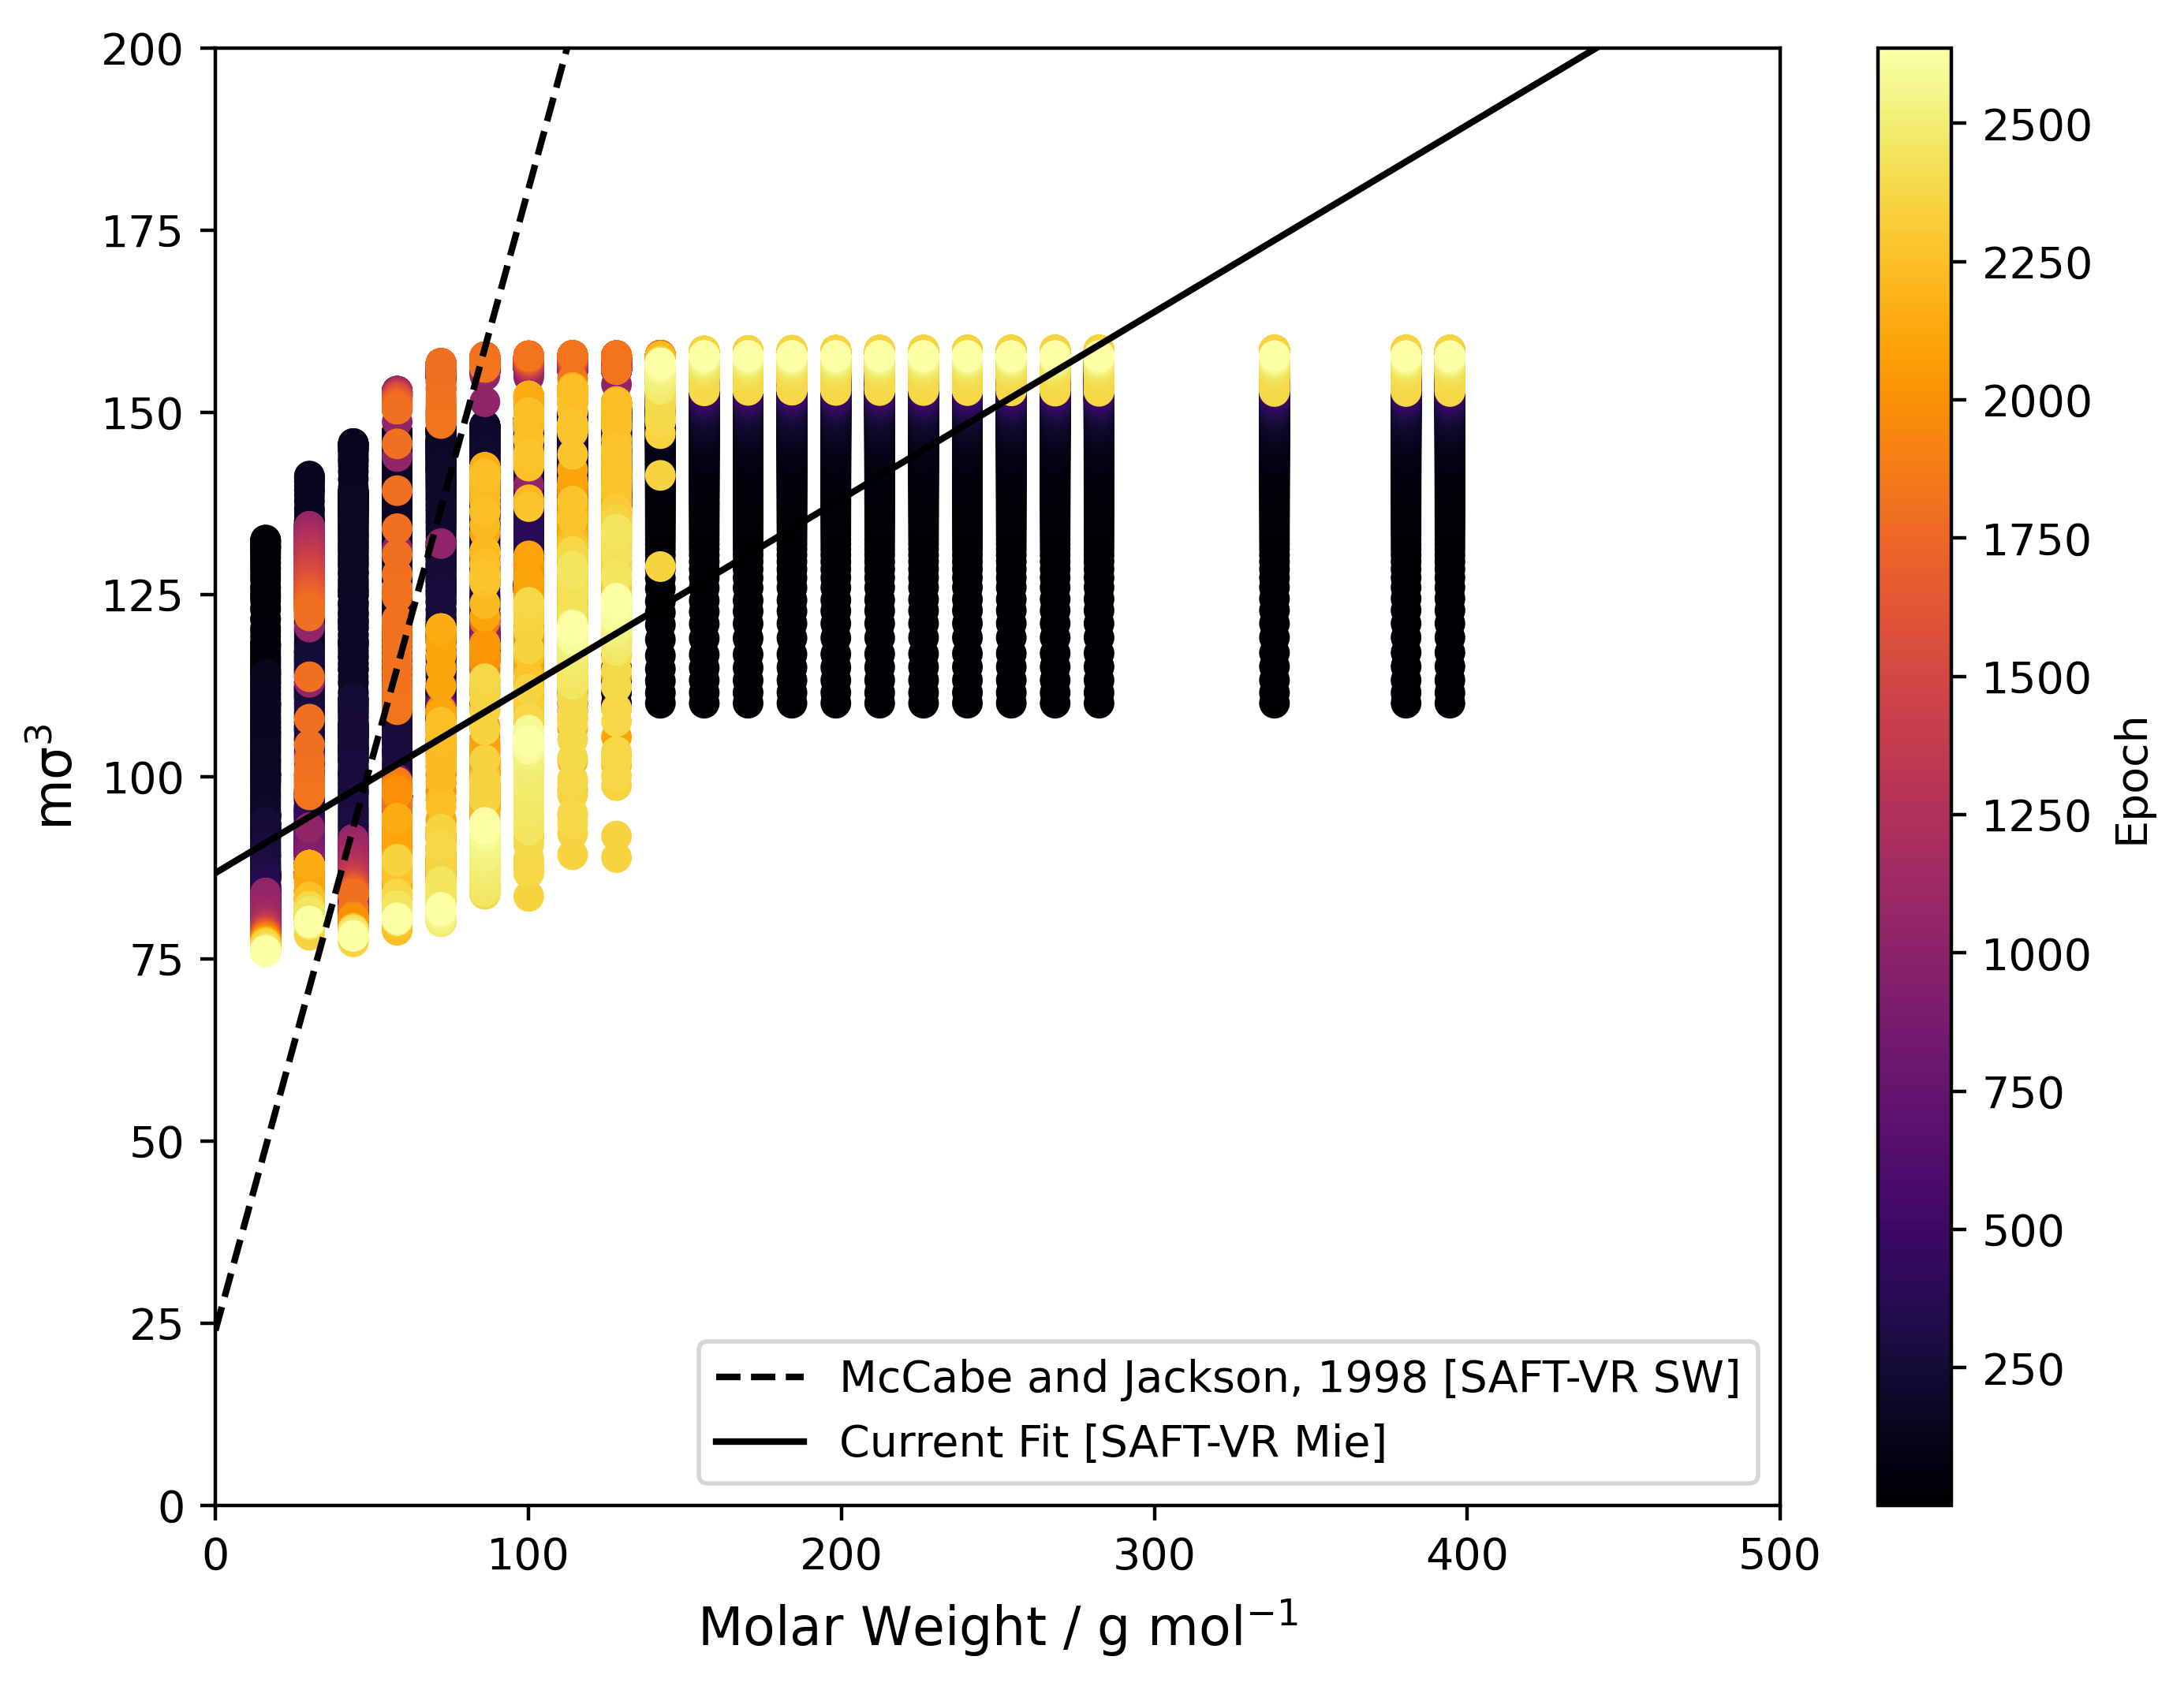

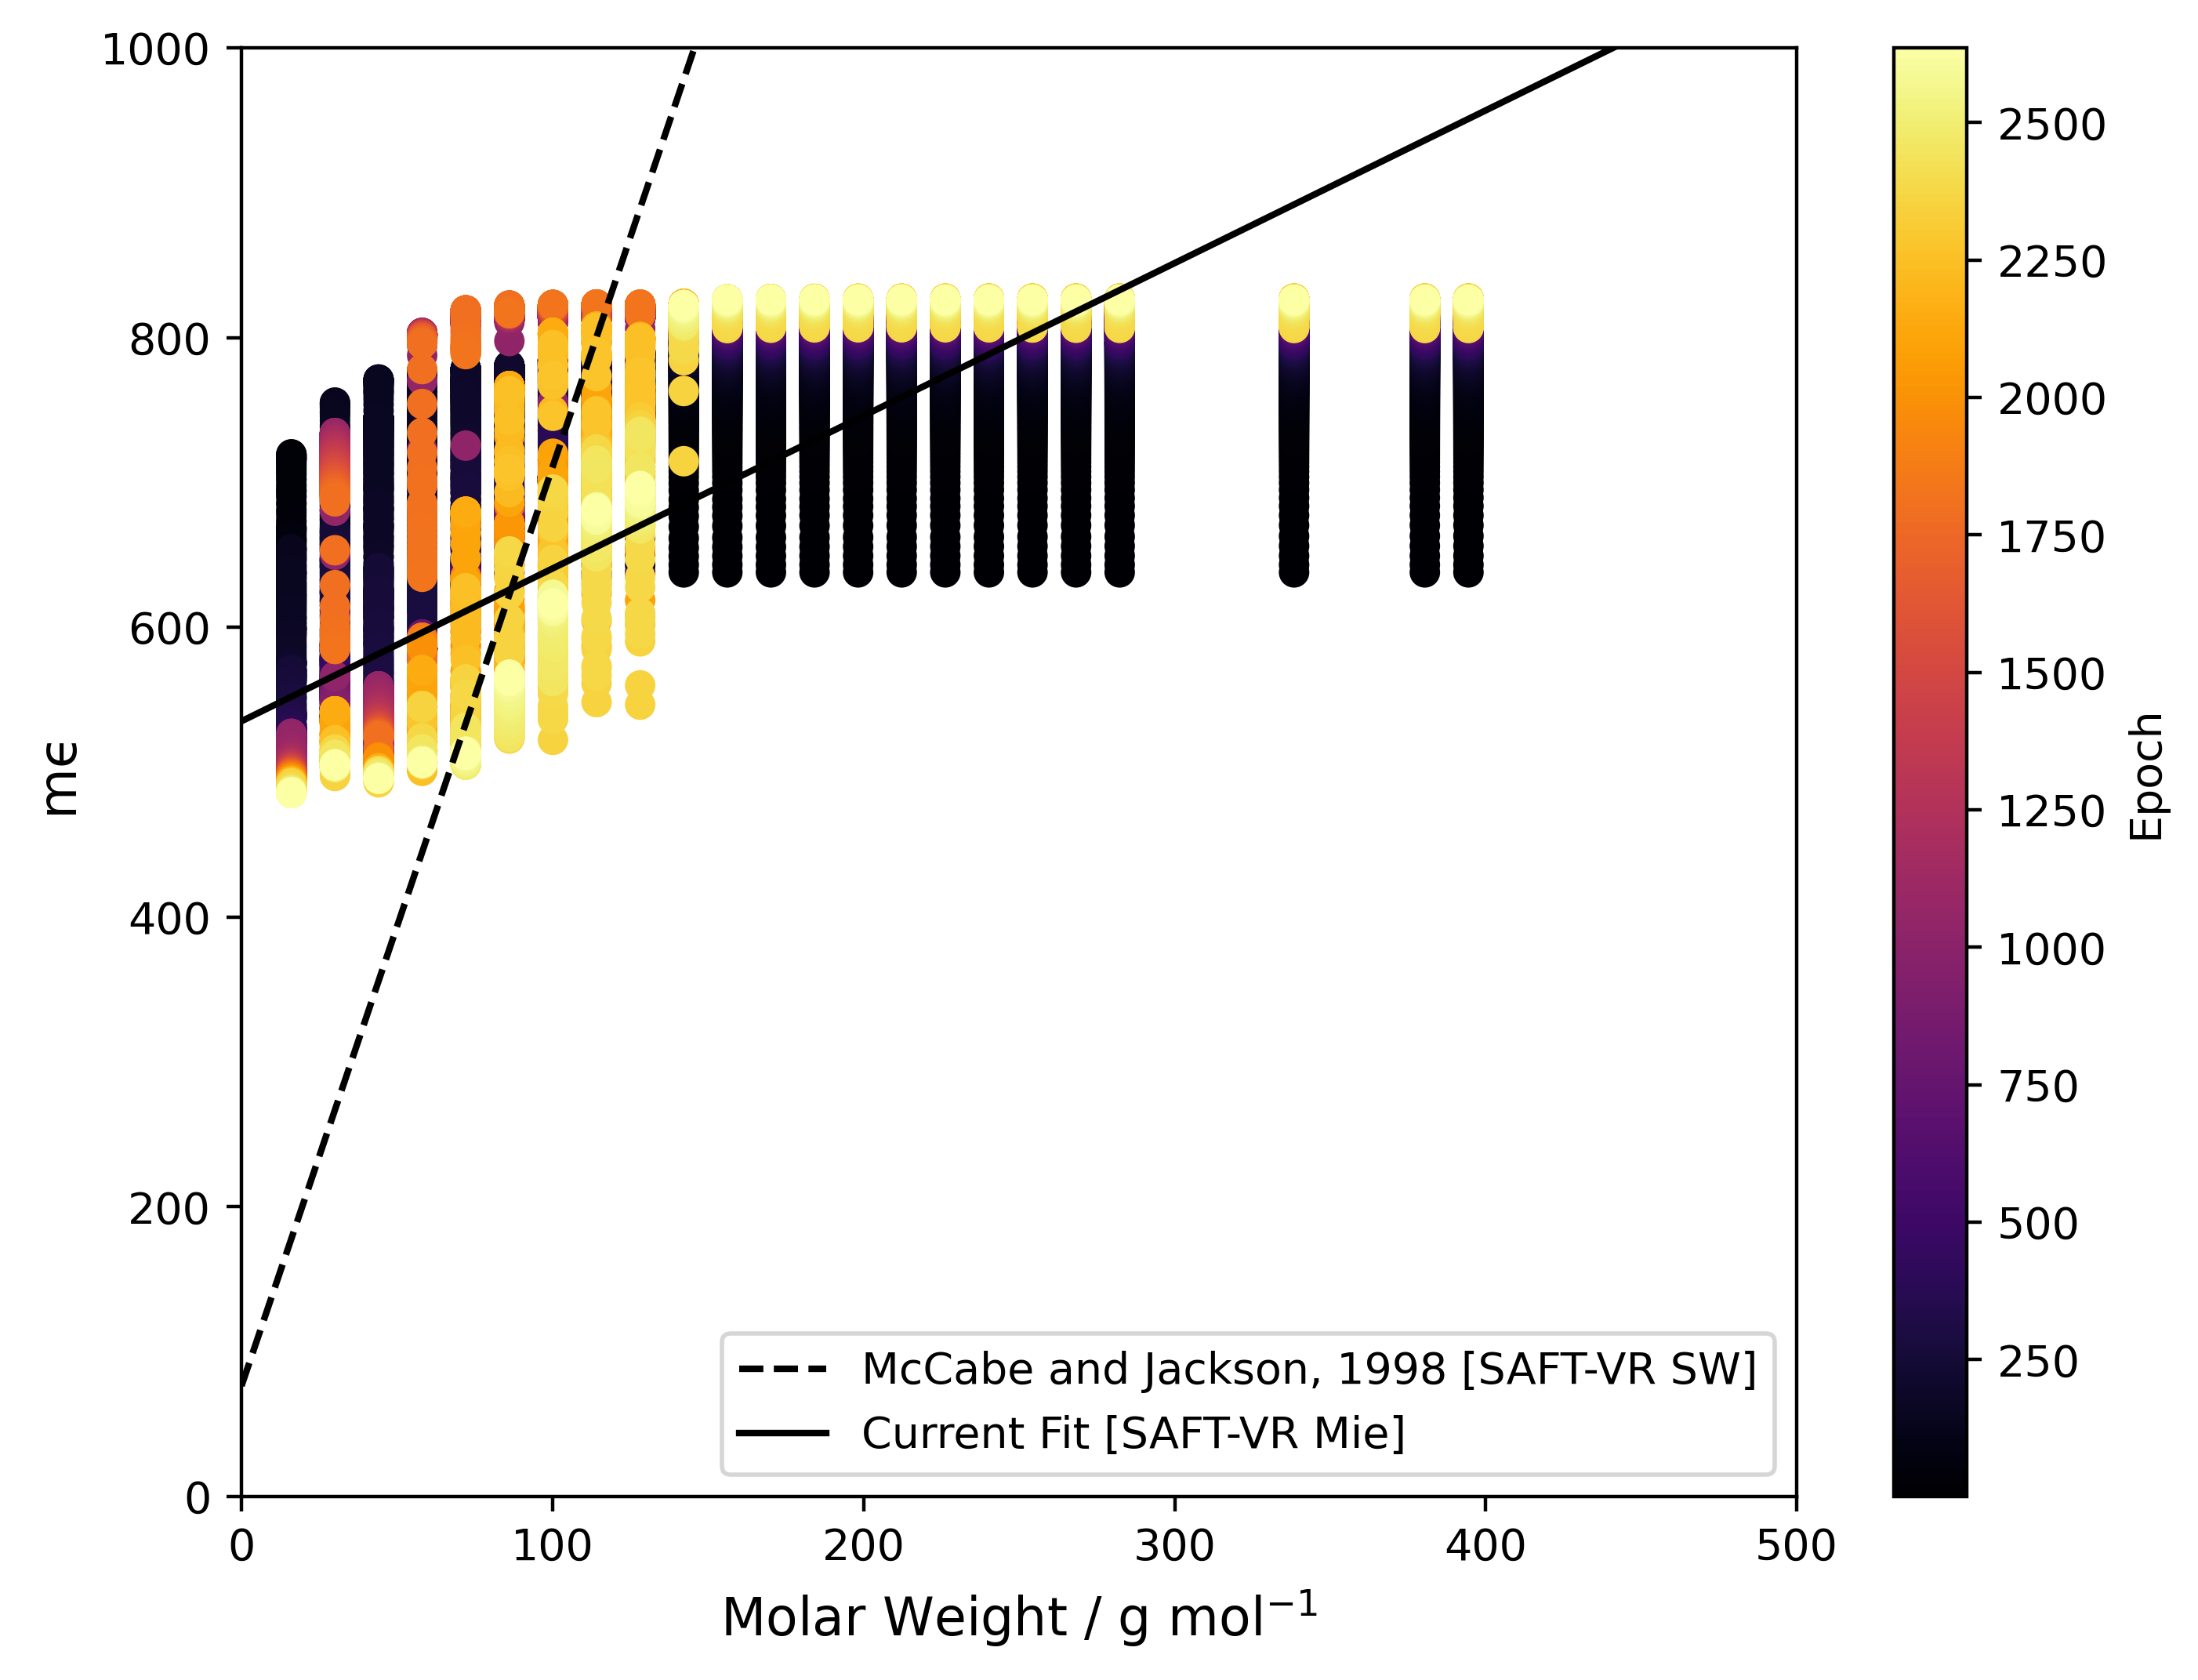

(0.0, 500.0)

In [41]:
num_epochs = length(processed_data[1,:m])

# mσ3 
plt.figure(figsize=(8, 6), dpi=400)
color_mapping = collect(range(1,num_epochs))

ideal_Mw = collect(range(0,500,500))
ideal_mσ3s = [1.566*i + 24.02 for i in ideal_Mw] 
current_mσ3s = [lin_fit_coeff_mσ3[2]*i + lin_fit_coeff_mσ3[1] for i in ideal_Mw] 
plt.plot(ideal_Mw, ideal_mσ3s, color = "k", "--")
plt.plot(ideal_Mw, current_mσ3s, color = "k")

for j = 1:nrow(processed_data)

    Mw = fill(processed_data[j,:Mw], num_epochs)
    ms = processed_data[j,:m]
    σs = processed_data[j,:σ]

    mσ3 = [ms[i]*σs[i]^3 for i in 1:num_epochs]
    plt.scatter(Mw, mσ3, c=color_mapping, cmap="inferno")
end

plt.colorbar(ticks = 0:250:num_epochs,label = "Epoch")

plt.legend(["McCabe and Jackson, 1998 [SAFT-VR SW]","Current Fit [SAFT-VR Mie]"], loc="lower right")
plt.xlabel("Molar Weight / g mol\$^{-1}\$",fontsize=12)
plt.ylabel("mσ\$^3\$",fontsize=12)
plt.ylim([0,200])
plt.xlim([0,500]) ;

# mϵ 
plt.figure(figsize=(8, 6), dpi=400)
color_mapping = collect(range(1,num_epochs))

ideal_mϵs= [6.343*i + 76.38 for i in ideal_Mw] 
current_mϵs = [lin_fit_coeff_mϵ[2]*i + lin_fit_coeff_mϵ[1] for i in ideal_Mw] 
plt.plot(ideal_Mw, ideal_mϵs, color = "k","--")
plt.plot(ideal_Mw, current_mϵs, color = "k")

for j = 1:nrow(processed_data)

    Mw = fill(processed_data[j,:Mw], num_epochs)
    ms = processed_data[j,:m]
    ϵs = processed_data[j,:ϵ]

    mϵ = [ms[i]*ϵs[i] for i in 1:num_epochs]

    plt.scatter(Mw, mϵ, c=color_mapping, cmap="inferno")
end

plt.colorbar(ticks = 0:250:num_epochs,label = "Epoch")

plt.legend(["McCabe and Jackson, 1998 [SAFT-VR SW]","Current Fit [SAFT-VR Mie]"], loc="lower right")
plt.xlabel("Molar Weight / g mol\$^{-1}\$",fontsize=12)
plt.ylabel("mϵ",fontsize=12) ;
plt.ylim([0,1000])
plt.xlim([0,500]) ;   

# plt.savefig("all_compound_phase_envelopes.png",dpi=400)

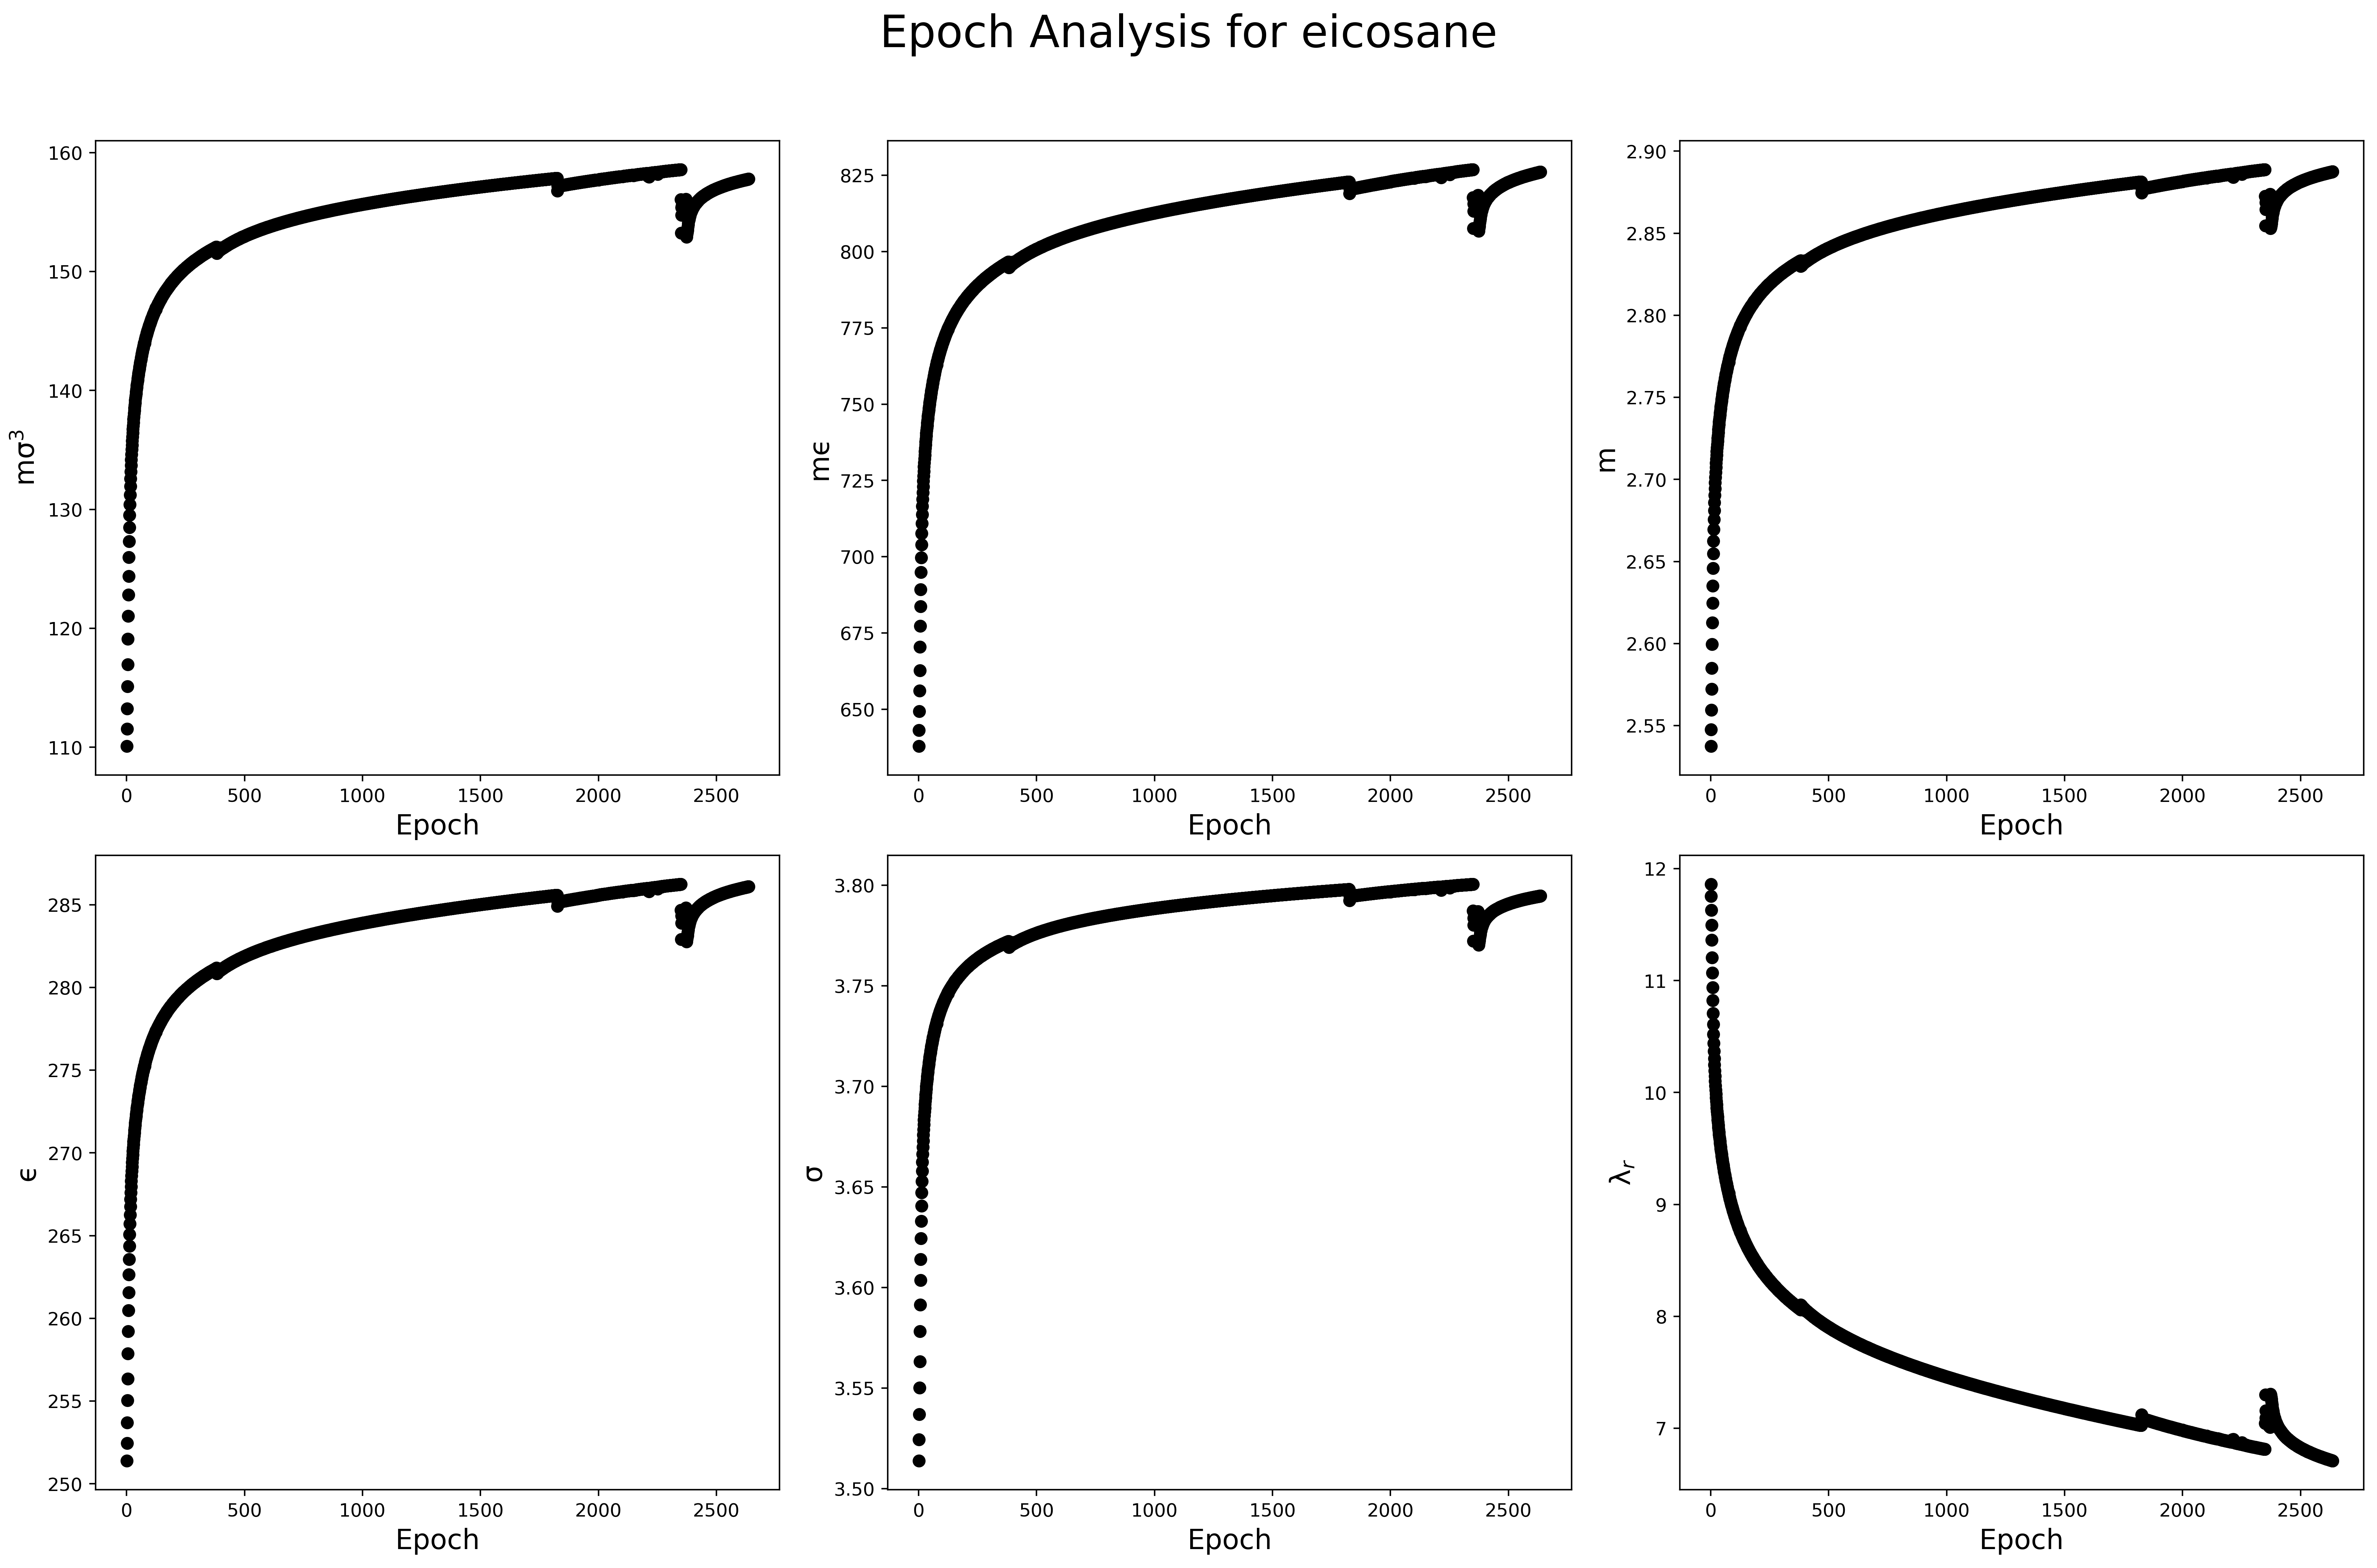

In [43]:
using PyPlot

test_species = "eicosane"
num_epochs = length(processed_data[1, :m])
epochs = collect(range(1, num_epochs))

processed_data_test_species = filter(row -> isequal(row.species, lowercase(test_species)), processed_data)

ms = processed_data_test_species[1, :m]
ϵs = processed_data_test_species[1, :ϵ]
σs = processed_data_test_species[1, :σ]
λ_rs = processed_data_test_species[1, :λ_r]

m_epsilon = [ms[i] * ϵs[i] for i in 1:num_epochs]
m_sigma_cubed = [ms[i] * σs[i]^3 for i in 1:num_epochs]

fig, axes = plt.subplots(2, 3, figsize=(18, 12), dpi=400)
fig.suptitle("Epoch Analysis for $test_species", fontsize=24)

# Plot m_sigma_cubed
axes[1, 1].scatter(epochs, m_sigma_cubed, color="k")
axes[1, 1].set_xlabel("Epoch", fontsize=15)
axes[1, 1].set_ylabel("mσ\$^3\$", fontsize=15)

# Plot m_epsilon
axes[1, 2].scatter(epochs, m_epsilon, color="k")
axes[1, 2].set_xlabel("Epoch", fontsize=15)
axes[1, 2].set_ylabel("mϵ", fontsize=15)

# Plot ms
axes[1, 3].scatter(epochs, ms, color="k")
axes[1, 3].set_xlabel("Epoch", fontsize=15)
axes[1, 3].set_ylabel("m", fontsize=15)

# Plot ϵs
axes[2, 1].scatter(epochs, ϵs, color="k")
axes[2, 1].set_xlabel("Epoch", fontsize=15)
axes[2, 1].set_ylabel("ϵ", fontsize=15)

# Plot σs
axes[2, 2].scatter(epochs, σs, color="k")
axes[2, 2].set_xlabel("Epoch", fontsize=15)
axes[2, 2].set_ylabel("σ", fontsize=15)

# Plot λ_as
axes[2, 3].scatter(epochs, λ_rs, color="k")
axes[2, 3].set_xlabel("Epoch", fontsize=15)
axes[2, 3].set_ylabel("λ\$_r\$", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


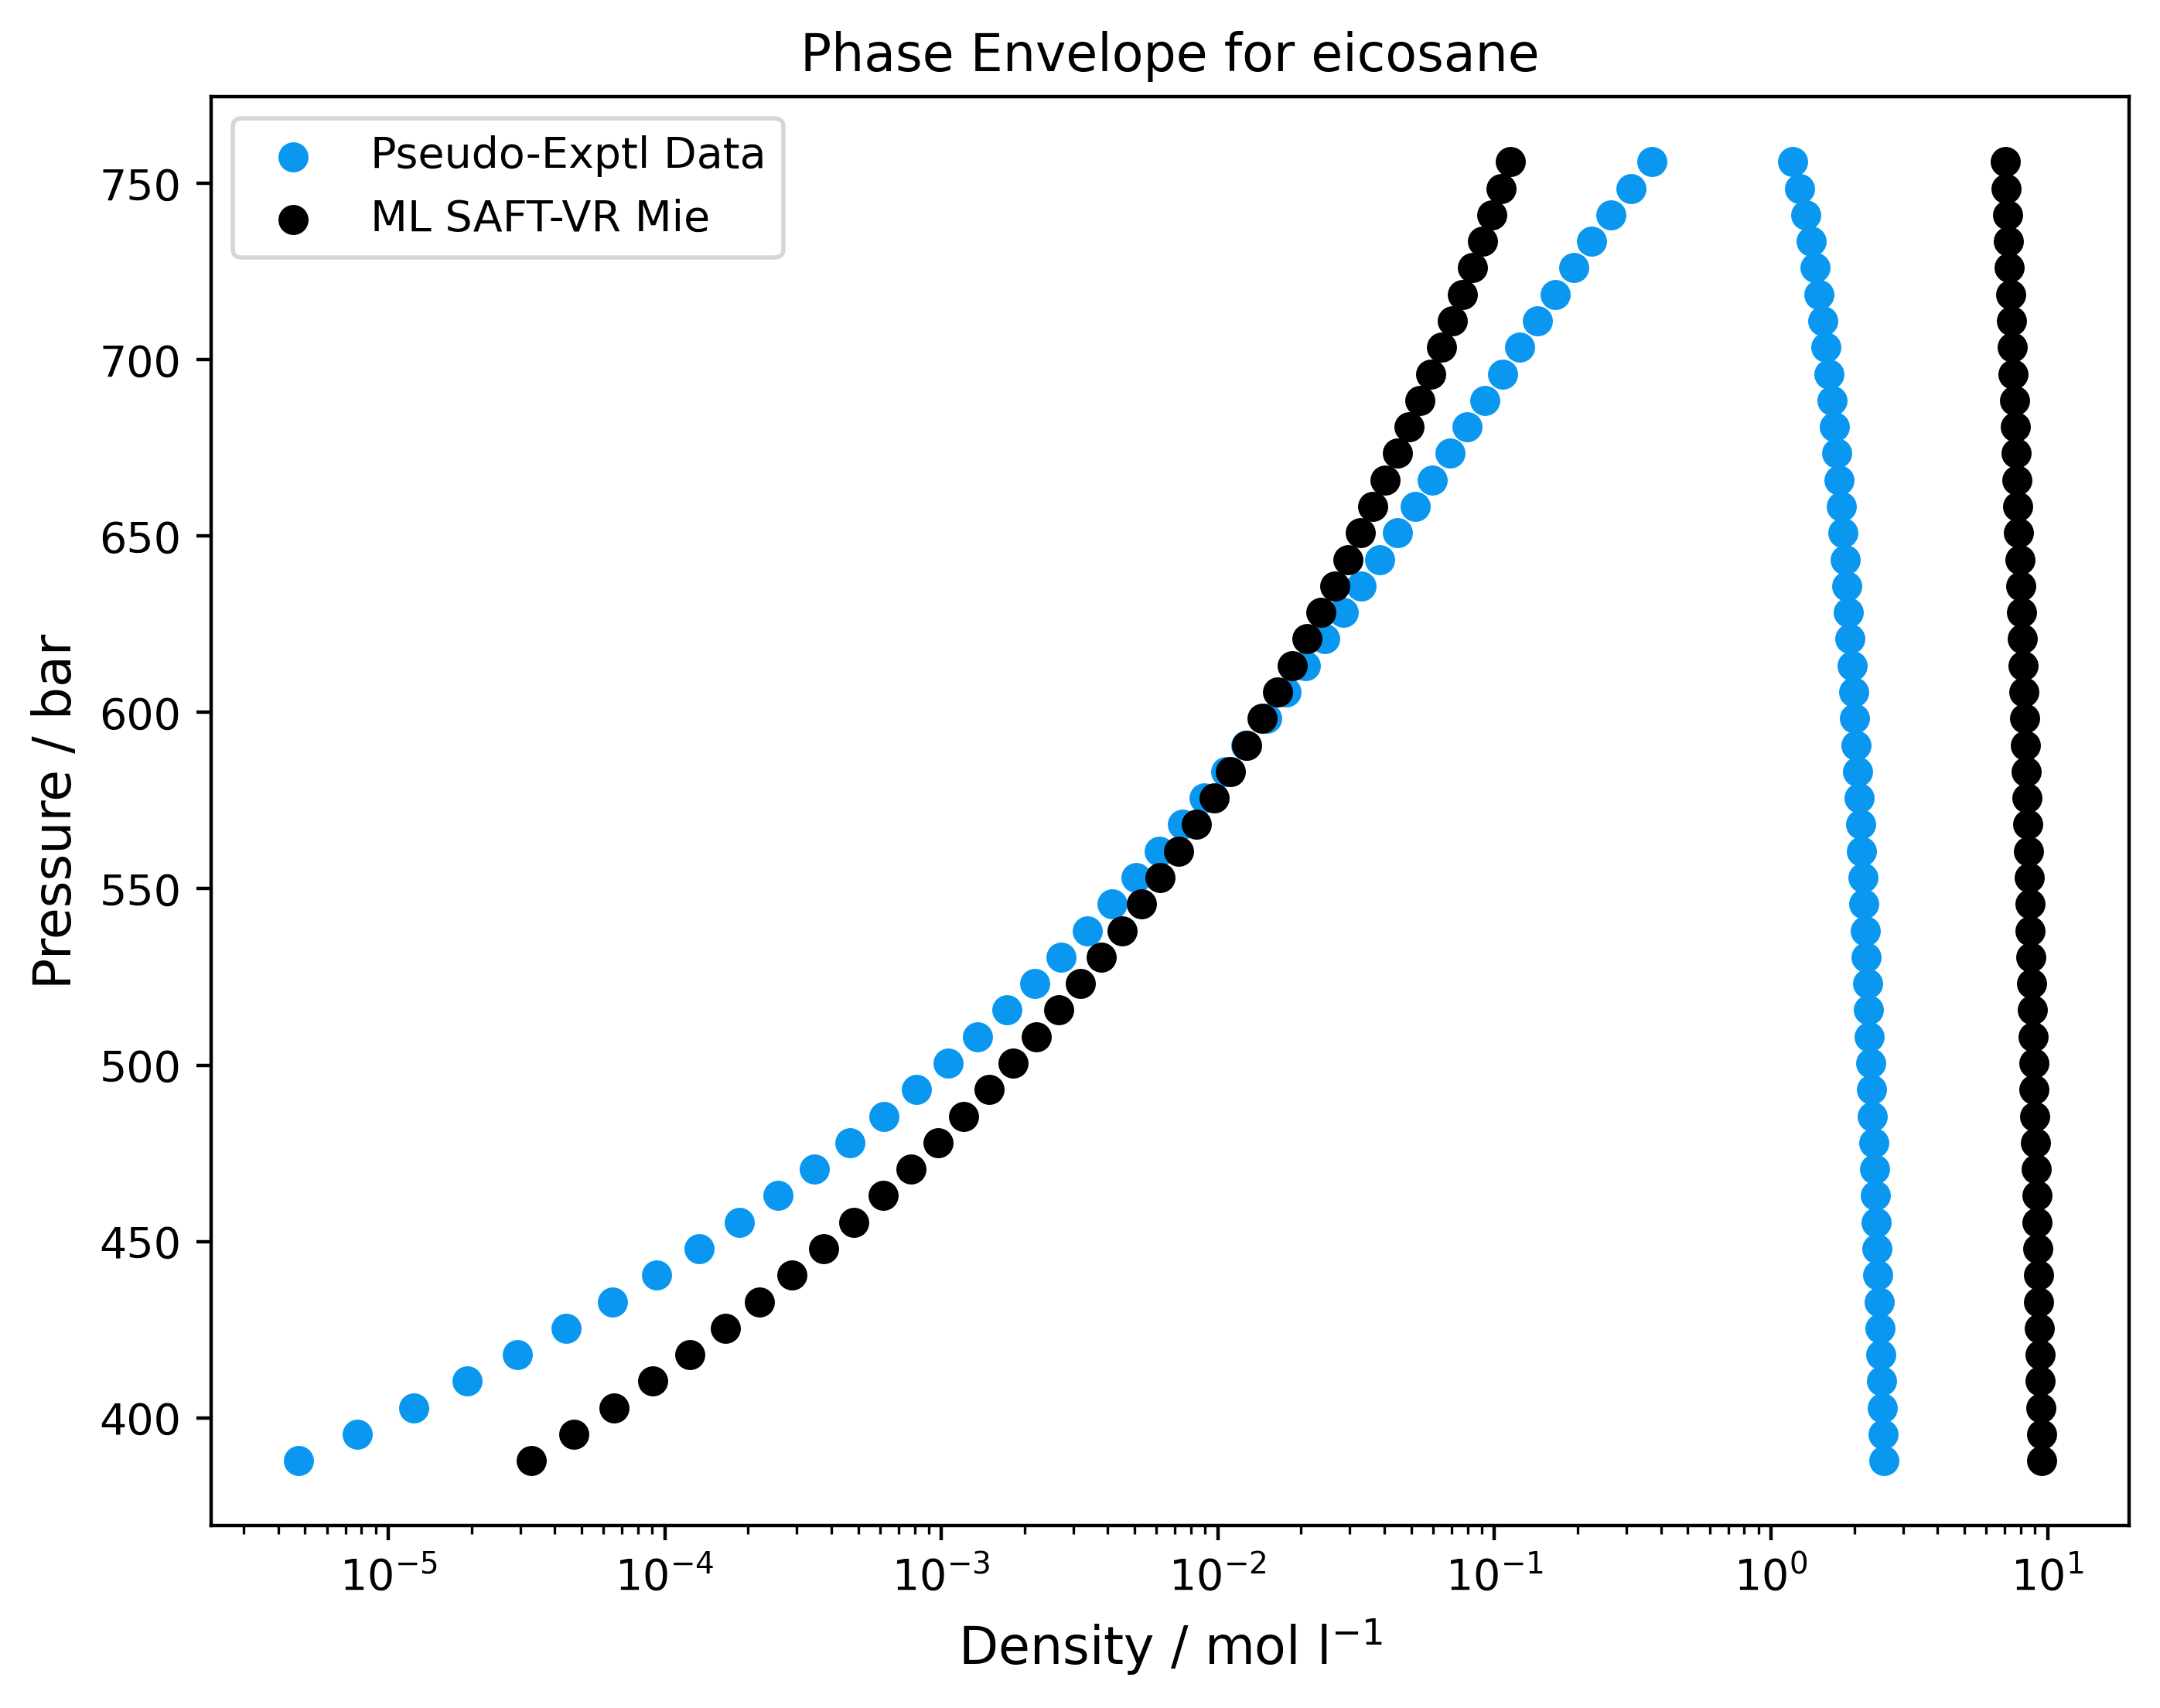

In [42]:
# Plot source pcp saft phase envelope (over given temperature range)

test_species = string("eicosane")

pcp_model = PPCSAFT([test_species])
Tc, pc, Vc = crit_pure(pcp_model)
T_range = range(0.5 * Tc, 0.975 * Tc, 50)
v_liq_range_pcp = []
v_vap_range_pcp = []
v_liq_range_vrmie = []
v_vap_range_vrmie = []

for T in T_range
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(pcp_model, T)
    push!(v_liq_range_pcp, v_liq_sat)
    push!(v_vap_range_pcp, v_vap_sat)
end

processed_data_test_species = filter(row -> isequal(row.species, lowercase(test_species)), processed_data)

Mw_test_species = processed_data_test_species[1,:Mw]
m_test_species = processed_data_test_species[1,:m][end]
σ_test_species = processed_data_test_species[1,:σ][end]
λ_a_test_species = processed_data_test_species[1,:λ_a][end]
λ_r_test_species = processed_data_test_species[1,:λ_r][end]
ϵ_test_species = processed_data_test_species[1,:ϵ][end]

vrmie_model = make_model(Mw_test_species, m_test_species, σ_test_species, λ_a_test_species, λ_r_test_species, ϵ_test_species)

for T in T_range
    (p_sat, v_liq_sat, v_vap_sat) = saturation_pressure(vrmie_model, T)
    push!(v_liq_range_vrmie, v_liq_sat)
    push!(v_vap_range_vrmie, v_vap_sat)
end


plt.figure(figsize=(8, 6), dpi=400)
plt.scatter(1e-3 ./v_liq_range_pcp, T_range,color="#0a97f0")
plt.scatter(1e-3 ./v_liq_range_vrmie, T_range,color="k")

plt.xscale("log")
plt.title("Phase Envelope for " * test_species)
plt.xlabel("Density / mol l\$^{-1}\$",fontsize=12)
plt.ylabel("Pressure / bar",fontsize=12)
plt.legend(["Pseudo-Exptl Data","ML SAFT-VR Mie"])

plt.scatter(1e-3 ./v_vap_range_pcp, T_range,color="#0a97f0")
plt.scatter(1e-3 ./v_vap_range_vrmie, T_range,color="k") ;

